RNN podemos usar, pero is complex to train with longer sequences and can suffer from the problem of vanishing gradients

Hay otra variaciones como LSTM and GRU que no tienen este problema.

In [16]:
import pandas as pd
import scipy.io
import os
import mne
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from datetime import datetime
from matplotlib import pyplot

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, Embedding
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

tf.random.set_seed(7)

## Data

### Split files per wildboard and compute the areas points

In [3]:
# USE fiwi for train. becuase other in the positions we dont have too much data

In [4]:
path_files_fiwi = "../Join/telemetriedaten/positions_weather_fiwi/"
# path_files_other = "../Join/telemetriedaten/positions_weather_other/"

path_place_fiwi = "../Join/telemetriedaten/TelemetrieFiwigatter/"
# path_place_other = "../Join/telemetriedaten/TelemetrieJagdgatter/"

save_file_path = "../Join/telemetriedaten/position_per_wild_fiwi/"

In [ ]:
list_files = os.listdir(path_files_fiwi)
wild_boards_fiwi = set()
for file in list_files:
    df = pd.read_csv(path_files_fiwi + file)
    wild_boards_fiwi.update(list(df["ID"].unique()))

# list_files = os.listdir(path_files_other)
# wild_boards_other = set()
# for file in list_files:
#     df = pd.read_csv(path_files_other + file)
#     wild_boards_other.update(list(df["ID"].unique()))

In [5]:
wild_boards_fiwi = {
    'VG.2013.01', 'IS.2011.13', 'FG.2013.16', 'FG.2016.16', 'FG.2013.32', 'FG.2017.12', 'LA.2011.01', 'IS.2011.27',
    'IS.2011.05', 'VG.2013.10', 'IS.2011.20', 'FG.2013.29', 'FG.2016.14', 'FG.2017.11', 'IS.2011.29', 'FG.2016.13', 'IS.2011.10', 
    'IS.2011.37', 'FG.2016.15', 'FG.2016.17', 'FG.2013.09', 'LA.2011.03', 'DE.2011.19', 'IS.2011.21', 'IS.2011.39', 'FG.2017.09', 
    'DE.2011.27', 'IS.2011.32', 'DE.2011.23', 'VG.2013.09', 'FG.2017.18', 'IS.2011.12', 'IS.2011.26', 'IS.2011.25', 'IS.2011.02', 
    'IS.2011.23', 'FG.2016.12', 'FG.2016.03', 'DE.2011.21', 'IS.2011.04', 'IS.2011.11', 'DE.2011.18', 'FG.2016.05', 'FG.2016.07', 
    'FG.2017.16', 'FG.2016.18', 'FG.2017.13', 'IS.2011.22', 'FG.2013.01', 'FG.2013.06', 'VG.2013.02', 'IS.2011.36', 'FG.2017.14', 
    'DE.2011.20', 'FG.2017.17', 'IS.2011.15', 'IS.2011.34', 'DE.2011.14', 'VG.2013.08', 'IS.2011.14', 'DE.2011.25', 'IS.2011.01', 
    'IS.2011.38', 'FG.2013.34', 'FG.2013.25', 'IS.2011.33', 'VG.2013.11'}

In [7]:
for wild in wild_boards_fiwi:
    if not os.path.exists(os.path.join(save_file_path,wild)):
        os.mkdir(os.path.join(save_file_path,wild))

In [8]:
list_files = os.listdir(path_files_fiwi)
for file in list_files:
    df = pd.read_csv(path_files_fiwi + file)
    for wild in wild_boards_fiwi:
        df_to_save = df[df["ID"]==wild]
        df_to_save.to_csv(os.path.join(save_file_path,wild,file))

/tmp/ipykernel_229/2223551429.py:3: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_files_fiwi + file)
/tmp/ipykernel_229/2223551429.py:3: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_files_fiwi + file)
/tmp/ipykernel_229/2223551429.py:3: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_files_fiwi + file)
/tmp/ipykernel_229/2223551429.py:3: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_files_fiwi + file)
/tmp/ipykernel_229/2223551429.py:3: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_files_fiwi + file)
/tmp/ipykernel_229/2223551429.py:3: DtypeWarning: Columns (11) have mixed types. Specify dtype optio

In [5]:
# Create file of areas

file_areas = "../Join/telemetriedaten/TelemetrieFiwigatter/TelemetrieFiwigatter_Tel.Fiwi.csv"

df = pd.read_csv(file_areas)
df["start"] = pd.to_datetime(df["start"], infer_datetime_format=True)   
df["end"] = pd.to_datetime(df["end"], infer_datetime_format=True)   

# , "ID" "location","start","end","duration"
# 0,"DE.2011.23","Fiwi",2017-02-01 15:55:08,2017-02-01 15:58:13,3.08333333333333

df_2016 = df[(df["start"] > datetime.strptime("2016-01-01", '%Y-%m-%d')) & (df["start"] < datetime.strptime("2016-12-31", '%Y-%m-%d'))]
df_2017 = df[(df["start"] > datetime.strptime("2017-01-01", '%Y-%m-%d')) & (df["start"] < datetime.strptime("2017-12-31", '%Y-%m-%d'))]
df_2018 = df[(df["start"] > datetime.strptime("2018-01-01", '%Y-%m-%d')) & (df["start"] < datetime.strptime("2018-12-31", '%Y-%m-%d'))]
df_2019 = df[(df["start"] > datetime.strptime("2019-01-01", '%Y-%m-%d')) & (df["start"] < datetime.strptime("2019-12-31", '%Y-%m-%d'))]

In [ ]:
# Unnamed: 0               0.0.5196
# ID                     DE.2011.14
# location                     Fiwi
# start         2017-12-20 13:42:06
# end           2017-12-20 13:42:06
# duration                      0.0
# Name: 78109, dtype: object

df_final = pd.DataFrame(columns=["ID","Date","x-value","y-value","location"])

# for index_data,df in [df_2016,df_2017,df_2018,df_2019]:
for index, row in df.iloc[78100:,:].iterrows():
    id = row["ID"]
    init = row["start"]
    end = row["end"]
    location = row["location"]
    list_dayofcount = [value.strftime("%Y-%m-%d") for value in pd.date_range(start=init,end=end).to_list()]
    for day in list_dayofcount:
        try:
            df_day = pd.read_csv(os.path.join("../Join/telemetriedaten/position_per_wild_fiwi/" + id + "/",day + "_fiwi.csv"))
            df_day["Date"] = pd.to_datetime(df_day["Date"], infer_datetime_format=True)   
            df_to_save = df_day[(df_day["Date"] > init) & (df_day["Date"] < end)][["ID","Date","x-value", "y-value"]]
            df_to_save['location'] = location
            df_final = pd.concat([df_final,df_to_save.iloc[:,:]])
        except Exception as e:
            pass
df_final.to_csv(f"../Join/telemetriedaten/areas.csv")
    # df_final.to_csv(f"../Join/telemetriedaten/areas_{index_data+16}.csv")

In [39]:
df_final.to_csv("../Join/telemetriedaten/areas.csv")

### Fechas juntas

In [ ]:
# Wild board DE.2011.14
df = pd.DataFrame()
for file in os.listdir("../Join/telemetriedaten/position_per_wild_fiwi/DE.2011.14/"):
    print(file)
    df_day = pd.read_csv("../Join/telemetriedaten/position_per_wild_fiwi/DE.2011.14/" + file)
    df_day = df_day[['Date', 'tagid', 'MACadresse', 'x-value', 'y-value', 'ID', 'TempMain', 
                      'HumMain', 'Wind','WindDir', 'Rain', 'Solar', 'TempBB', 'TempForest', 'HumForest',
                      'BaroPressure', '°C_FG', 'hum_FG', 'dew_p_FG', '°C_VG', 'hum_VG', 'dew_p_VG', 'SuhlenVG', 'SuhlenFG']]
    df = pd.concat([df,df_day.iloc[:,:]])
df.to_csv("../Join/telemetriedaten/position_per_wild_fiwi/DE.2011.14/DE.2011.14.csv")

### Prepare files

## Data preparation

In [3]:
# Wild board DE.2011.14
path_file = "../Join/telemetriedaten/position_per_wild_fiwi/DE.2011.14/DE.2011.14.csv"
df = pd.read_csv(path_file)
df = df.set_index('Date')
df = df.drop(columns=["Unnamed: 0","tagid","MACadresse","ID"])
ohe = pd.get_dummies(df.WindDir)
df = df.drop('WindDir',axis = 1)
# df = df.join(ohe)

/tmp/ipykernel_17892/693688132.py:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_file)


In [4]:
# LSTMs are sensitive to the scale of the input data

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0,1))
df[['TempMain', 'HumMain', 'Wind', 'Rain', 'Solar','TempBB', 'TempForest',
    'HumForest', 'BaroPressure', '°C_FG', 'hum_FG', 'dew_p_FG', '°C_VG',
    'hum_VG', 'dew_p_VG', 'SuhlenVG', 'SuhlenFG']] = scaler.fit_transform(df[['TempMain', 'HumMain', 'Wind', 'Rain', 'Solar',
                                                                              'TempBB', 'TempForest', 'HumForest', 'BaroPressure', '°C_FG', 'hum_FG',
                                                                              'dew_p_FG', '°C_VG', 'hum_VG', 'dew_p_VG', 'SuhlenVG', 'SuhlenFG']])
values = df.values
values = values.astype('float32')

In [9]:
df_temporal = df.copy()#.iloc[0:10000,:]
df_temporal[["x-value","y-value"]] = df_temporal[["x-value","y-value"]].shift(-1)
df_temporal = df_temporal.dropna(subset=["x-value","y-value"])

/tmp/ipykernel_17892/981266421.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temporal[["x-value","y-value"]] = df_temporal[["x-value","y-value"]].shift(-1)


In [10]:
# Split dataset 

values = df_temporal.values
length = values.shape[0]

train, validation, test = np.split(df_temporal, [int(.8 * len(df_temporal)), int(.9 * len(df_temporal))])


X_train, y_train = train.drop(columns=["x-value","y-value"]).values,  train[["x-value","y-value"]].values
X_validation, y_validation = validation.drop(columns=["x-value","y-value"]).values,  validation[["x-value","y-value"]].values
X_test, y_test = test.drop(columns=["x-value","y-value"]).values,  test[["x-value","y-value"]].values

In [11]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_validation = X_validation.reshape((X_validation.shape[0], 1, X_validation.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [12]:
print(X_train.shape, y_train.shape, X_validation.shape, y_validation.shape, X_test.shape, y_test.shape)

(7999, 1, 17) (7999, 2) (1000, 1, 17) (1000, 2) (1000, 1, 17) (1000, 2)


## Model and miscelaneous

In [13]:
def create_LSTM_model(data, data_size):
    model = Sequential()
    # Masking layer for pre-trained embeddings
    model.add(LSTM(units=data_size, input_shape=(data.shape[1], data.shape[2])))
    # Fully connected layer
    model.add(Dense(64, activation='relu'))
    # Dropout for regularization
    model.add(Dropout(0.5))
    # Output layer
    model.add(Dense(2, activation='softmax'))
    return model

model = create_LSTM_model(X_train,2048)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

2023-01-16 00:17:08.468481: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-16 00:17:08.468717: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-16 00:17:08.468986: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-01-16 00:17:08.469079: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-01-16 00:17:08.469158: W tensorf

## Train model

In [14]:
# Create callbacks
callbacks = [
                EarlyStopping(monitor='val_loss', patience=5),
                ModelCheckpoint('../models/model.h5', save_best_only=True, save_weights_only=False),
                CSVLogger('training.log')
            ]

In [15]:
history = model.fit(X_train,  y_train, 
                    batch_size=2048, epochs=10,
                    callbacks=callbacks,
                    validation_data=(X_validation, y_validation))

Epoch 1/10
4/4 [==============================] - 6s 1s/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 1.0000
Epoch 2/10
4/4 [==============================] - 3s 842ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 1.0000
Epoch 3/10
4/4 [==============================] - 3s 769ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 1.0000
Epoch 4/10
4/4 [==============================] - 3s 804ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 1.0000
Epoch 5/10
4/4 [==============================] - 3s 787ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 1.0000


## Results

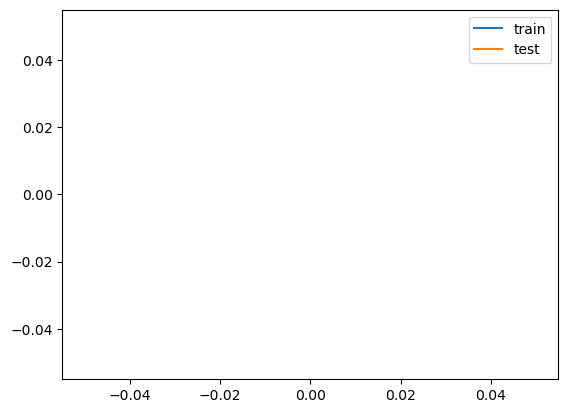

In [17]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [18]:
from sklearn.metrics import mean_squared_error
import math

# make a prediction
yhat = model.predict(X_test)
test_X = X_test.reshape((X_test.shape[0], X_test.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = y_test.reshape((len(y_test), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

32/32 [==============================] - 1s 9ms/step


ValueError: operands could not be broadcast together with shapes (1000,18) (17,) (1000,18) 